Read in the data

In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv('input/train.csv', index_col='id')
test = pd.read_csv('input/test.csv', index_col='id')

train['teacher_prefix'].fillna("Unknown", inplace=True)
train['project_essay_3'].fillna("", inplace=True)
train['project_essay_4'].fillna("", inplace=True)

test['teacher_prefix'].fillna("Unknown", inplace=True)
test['project_essay_3'].fillna("", inplace=True)
test['project_essay_4'].fillna("", inplace=True)

# Data Exploration

## Prior submissions

How does total submissions effect acceptance rate?

In [3]:
import matplotlib.pyplot as plt

prior_submit = train['teacher_number_of_previously_posted_projects']
accepted = train['project_is_approved']
submit_accepted = pd.DataFrame({'submissions': prior_submit.copy(), 'accepted': accepted.copy()})
grouped_submissions = submit_accepted.sort_values('submissions').groupby('submissions')
accept_rate = grouped_submissions.mean()
accept_rate['total_submissions'] = grouped_submissions.sum()

accept_rate.plot(y='accepted',
                 title='Acceptance rate by # of prior submissions',
                 ylim=[0.75,1])
accept_rate.plot(y='total_submissions',
                 title='Total submissions per # of prior submissions')
accept_rate.plot(y='total_submissions',
                 title='Total submissions per # of prior submissions (log scale)',
                 logy=True)
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

There is a clear increase in acceptance rate from teachers with prior submissions, until the data becomes noisy due to low submission rates above 50 prior submissions.

In general, teachers with more prior submissions are more likely to have their submission accepted. The data becomes noisy at high number of prior submissions because very few submissions have more than 200 prior submissions. Binning the data can help deal with this noise.

[  0.   1.   4.  12. 451.]


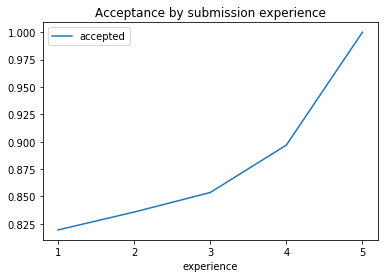

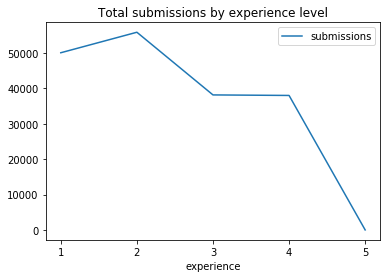

In [4]:
# Create equal sized bins, and digitize into experience levels
bins = pd.qcut(x=submit_accepted['submissions'], 
               q=5,
               duplicates='drop', 
               retbins=True)[1]
print(bins)
submit_accepted['experience'] = np.digitize(submit_accepted['submissions'], bins)

# Calculate acceptance rate per experience level
grouped_submissions = submit_accepted.drop('submissions', axis=1).sort_values('experience').groupby('experience')
accept_rate = grouped_submissions.mean()
accept_rate['submissions'] = grouped_submissions.count()
accept_rate.plot(y='accepted',
                 xticks=range(1, len(accept_rate.index)+1),
                 title="Acceptance by submission experience")
accept_rate.plot(y='submissions',
                 xticks=range(1, len(accept_rate.index)+1),
                 title='Total submissions by experience level')

These bins provide a relatively equal distribution of total submissions per experience level, while demonstrating a clear correlation between experience and acceptance rate. This would make a good feature. 

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, X, *_):
        return self

    def transform(self, X, *_):
        return X[self.col]
    

class Digitize(BaseEstimator, TransformerMixin):
    def __init__(self, binsize=5):
        self.binsize = binsize
        
    def fit(self, X, *_):
        self.bins = pd.qcut(x=X, 
                            q=self.binsize,
                            duplicates='drop', 
                            retbins=True)[1]
        return self
    
    def transform(self, X, *_):
        out = np.digitize(X, self.bins)[:,None]
        return out
    
experience = Pipeline([
    ('select', ColumnSelector('teacher_number_of_previously_posted_projects')),
    ('digitize', Digitize())
])

## Text Analysis

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

class ColumnJoiner(BaseEstimator, TransformerMixin):
    def __init__(self, in_cols):
        self.in_cols = in_cols
    
    def fit(self, X, *_):
        return self
    
    def transform(self, X, *_):
        self.out = X[self.in_cols[0]]
        for col in self.in_cols[1:]:
            self.out = self.out + X[col]
        return self.out

class Tfidf(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=10):
        self.tfv = TfidfVectorizer(max_features=max_features, stop_words='english')
        
    def fit(self, X, *_):
        self.tfv.fit(X)
        return self
    
    def transform(self, X, *_):
        out = pd.SparseDataFrame(self.tfv.transform(X),
                         columns=self.tfv.get_feature_names(), 
                         default_fill_value=0)
        return out

tfidf = Pipeline([
    ('join', ColumnJoiner(['project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4'])),
    ('tfidf', Tfidf())
])

# Final Data Pipeline

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

one_hot = make_column_transformer(
    (OneHotEncoder(sparse=False), ['teacher_prefix', 'project_grade_category']),
    remainder='drop'
)

In [8]:
from sklearn.pipeline import FeatureUnion

feature_engineering = FeatureUnion([
    ('experience', experience),
    ('tfidf', tfidf),
    ('one_hot', one_hot)
])

# Learning

A Random Forest Classifier is used with cross validation to find the accuracy of the current model

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = train['project_is_approved']
X_train, X_test, y_train, y_test = train_test_split(train, y)

rfc = RandomForestClassifier(n_estimators=100)
pipeline = Pipeline([
    ('feature_engineering', feature_engineering),
    ('classify', rfc)
])

In [50]:
pipeline.fit(train, y)
res_prob = pipeline.predict_proba(test)

In [45]:
probs = pd.DataFrame(res_prob, index=test.index)
final = pd.concat([test, probs], axis=1)
submit = pd.DataFrame(final[1]).rename({1: 'project_is_approved'}, axis='columns')
submit.head()

,project_is_approved
id,
p233245,0.9
p096795,0.8
p236235,0.9
p233680,0.8
p171879,0.9


In [47]:
submit.to_csv('predictions.csv', header=True)